In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from torch import nn
import numpy as np

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
class EncodedDataset(Dataset):
    def __init__(self, final_embeddings, final_labels):
        super().__init__()
        self.final_embeddings = final_embeddings
        self.final_labels = final_labels
    
    def __getitem__(self, index):
        return (
            self.final_embeddings[index],
            self.final_labels[index],
        )

    def __len__(self):
        return self.final_embeddings.shape[0]

# Autoencoder

In [5]:
import torch
from src.mnist_autoencoder import Autoencoder, train
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

In [6]:
mnist_data = datasets.MNIST(
    "data", train=True, download=True, transform=transforms.ToTensor()
)
mnist_data_encoder = list(mnist_data)[:4096]

In [7]:
train_loader = torch.utils.data.DataLoader(
        mnist_data_encoder, batch_size=64, shuffle=True
    )

In [8]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, train_loader, num_epochs=max_epochs)

Epoch:1, Loss:0.0733
Epoch:2, Loss:0.0629
Epoch:3, Loss:0.0577
Epoch:4, Loss:0.0365
Epoch:5, Loss:0.0249
Epoch:6, Loss:0.0221
Epoch:7, Loss:0.0176
Epoch:8, Loss:0.0144
Epoch:9, Loss:0.0126
Epoch:10, Loss:0.0114
Epoch:11, Loss:0.0126
Epoch:12, Loss:0.0108
Epoch:13, Loss:0.0093
Epoch:14, Loss:0.0092
Epoch:15, Loss:0.0080
Epoch:16, Loss:0.0080
Epoch:17, Loss:0.0071
Epoch:18, Loss:0.0071
Epoch:19, Loss:0.0068
Epoch:20, Loss:0.0067


# Train and sample datasets

In [9]:
sample_mnist_data_clf = list(mnist_data)[4096:4096*2]

In [10]:
train_mnist_data_clf = list(mnist_data)[4096*2:int(4096*4)]

# train

In [11]:
from src.gat_classifier import Net

In [106]:
n = Net(num_classes=10,
        encoder_model=model,
        sample_dataset=sample_mnist_data_clf,
        train_dataset=train_mnist_data_clf,
        num_epochs=10,
        learning_rate=1e-3,
        seed=42,
        use_graph=False)

In [107]:
loss = n.train()

100%|██████████| 128/128 [00:00<00:00, 323.25it/s]


In [108]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [109]:
all_losses = []
index = 0
for i,x in enumerate(loss):
    for j,y in enumerate(x):
        all_losses.append({"counter":index,"epoch":i+1,"iteration":j+1,"loss":y})
        index+=1

In [110]:
loss_df = pd.DataFrame(all_losses)

<AxesSubplot:xlabel='counter', ylabel='loss'>

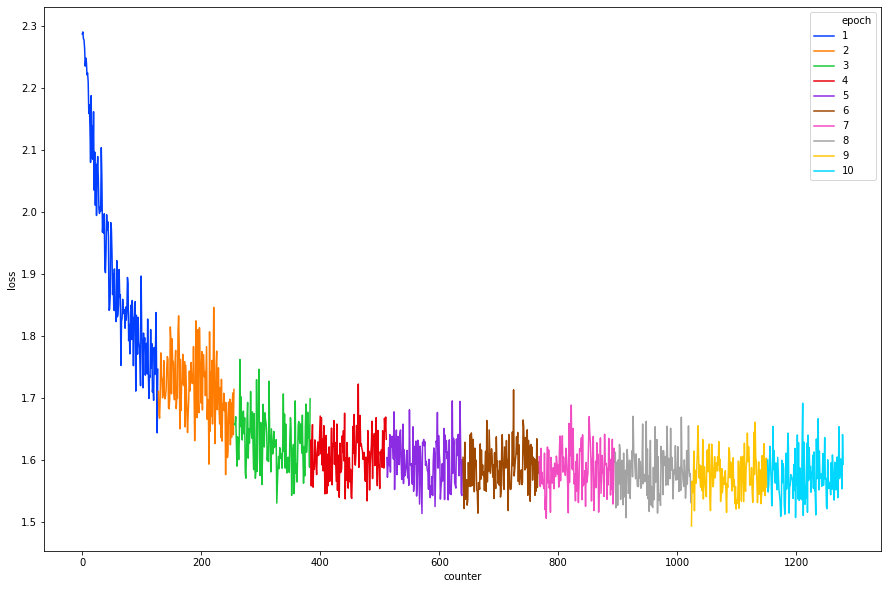

In [111]:
plt.figure(figsize=(15,10))
sns.lineplot(data=loss_df,x="counter",y="loss",hue="epoch",palette=sns.color_palette("bright",n_colors=len(loss_df.epoch.unique())))

In [112]:
mnist_data_clf_test = list(mnist_data)[4096*5:4096*8]

In [113]:
len(mnist_data_clf_test)

12288

In [114]:
clf_test_loader = n.get_encoding(mnist_data_clf_test,64)

In [115]:
from tqdm import tqdm

In [116]:
res = []
for data in tqdm(clf_test_loader):
    img, label = data
    recon = n.forward(img)
    _, preds = torch.max(recon, 1)
    bool_tensor = preds == label
    res.append(torch.stack([label,bool_tensor,preds],dim=1))

100%|██████████| 192/192 [00:00<00:00, 654.41it/s]


In [117]:
all_res = torch.cat(res,dim=0)

In [118]:
import numpy as np

In [119]:
df_test_res = pd.DataFrame(all_res.numpy(),columns=["class","res","pred_class"])

# w/o graph

In [121]:
df_test_res.groupby("res").count()/df_test_res.shape[0]

,class,pred_class
res,,
0,0.06779,0.06779
1,0.93221,0.93221


# w graph

In [103]:
df_test_res.groupby("res").count()/df_test_res.shape[0]

,class,pred_class
res,,
0,0.127686,0.127686
1,0.872314,0.872314


# w/o graph

In [122]:
confusion_matrix = pd.crosstab(df_test_res['class'], df_test_res['pred_class'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,935,1,19,9,0,90,84,4,24,13
1,0,1378,14,3,1,2,1,2,2,2
2,0,10,1172,29,7,3,6,10,7,1
3,0,3,8,1160,0,26,0,3,15,5
4,1,2,12,2,1132,2,10,4,2,26
5,1,8,4,16,3,1095,6,2,11,8
6,0,6,1,1,3,33,1179,0,4,0
7,1,12,19,15,11,1,1,1177,2,13
8,0,16,5,20,2,19,13,1,1106,8


# w graph

In [105]:
confusion_matrix = pd.crosstab(df_test_res['class'], df_test_res['pred_class'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,539,2,20,4,3,17,530,11,37,16
1,0,1361,6,5,3,2,2,4,16,6
2,1,2,1120,11,8,2,22,51,19,9
3,2,8,48,1046,4,31,5,21,41,14
4,1,2,10,0,1106,0,12,4,16,42
5,2,4,4,18,17,1021,30,7,41,10
6,0,4,3,2,6,17,1179,0,16,0
7,1,4,5,1,10,0,2,1195,18,16
8,0,19,18,21,9,20,13,7,1056,27
